In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy

import numpy as np

# Descriptive analysis

In [50]:
df_ops = pd.read_csv('../data/frames/ops.final')
print(df_ops.head(3))
print(df_ops['indeg'].max())

   indeg  outdeg  age  nuniqs      bows          sems  isunk  ninetyfive  \
0      0       0  145     416  4.540803  4.395973e-49      0           0   
1      1       8   21     457  3.347616  2.018162e-04      0           0   
2      0       7   27     565  2.213153  0.000000e+00      1           0   

   ninety percentile  log(degree)  
0       0       <=90     0.000000  
1       0       <=90     0.693147  
2       0       <=90     0.000000  
3992


In [51]:
df_dblp = pd.read_csv('../data/frames/dblp.final')
df_dblp.head(3)

,indeg,outdeg,year,authors,nuniqs,bows,lang,word,sems,age,isunk,ninety,ltninety,isunk.1,ninetyfive
0,9,2,1999,3,64,13.954760,en,UNK,0.000,19,1,0,1,1,0
1,10,3,1999,2,56,17.225665,en,UNK,0.000,19,1,0,1,1,0
2,14,0,2008,4,106,6.484922,en,grey,0.003,10,0,1,0,0,1


In [52]:
# for simplicity, let's remove docs which don't hit the lexicon
# results are basically the same if you don't do this
drop_misses = True
if drop_misses:
    df_ops = df_ops[df_ops['sems']>0]
    df_dblp = df_dblp[df_dblp['sems']>0]

Now let's bin the citations to make it easier to make figures

In [53]:
df_ops['citebins'] = pd.cut(df_ops['indeg'],[-1,0,5,20,100000])
print("OPS\n",df_ops['citebins'].value_counts())
df_dblp['citebins'] = pd.cut(df_dblp['indeg'],[-1,0,5,20,100000])
print("\nDBLP\n",df_dblp['citebins'].value_counts())

OPS
 (-1, 0]         2163
(0, 5]          2037
(5, 20]         1836
(20, 100000]    1508
Name: citebins, dtype: int64

DBLP
 (0, 5]          12160
(-1, 0]         12148
(20, 100000]    10338
(5, 20]          9084
Name: citebins, dtype: int64


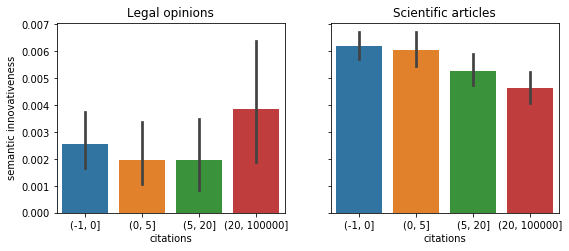

In [54]:
fig,ax = plt.subplots(1,2,figsize=[9,3.5],sharey=True)
sns.barplot(x='citebins',y='sems',data=df_ops,ax=ax[0])#,kind='point')
ax[0].set_ylabel('semantic innovativeness')
ax[0].set_xlabel('citations');
ax[0].set_title('Legal opinions')

sns.barplot(x='citebins',y='sems',data=df_dblp,ax=ax[1])#,kind='point')
ax[1].set_xlabel('citations');
ax[1].set_ylabel('')
ax[1].set_title('Scientific articles');

For legal documents, highly cited articles are more innovative. Not so for DBLP.

Now let's bin the semantic innovativeness feature.

In [55]:
# quartile-ish bins of the innovation feature  
df_ops['sem_q'] = pd.qcut(df_ops['sems'],6,duplicates='drop')
df_dblp['sem_q'] = pd.qcut(df_dblp['sems'],18,duplicates='drop')

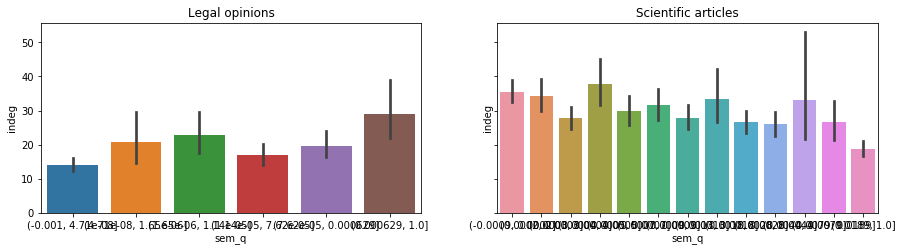

In [56]:
fig,ax = plt.subplots(1,2,figsize=[15,3.5],sharey=True)

sns.barplot(y='indeg',x='sem_q',data=df_ops,ax=ax[0]);
ax[0].set_title('Legal opinions')
sns.barplot(y='indeg',x='sem_q',data=df_dblp,ax=ax[1]);
ax[1].set_title('Scientific articles');

Pretty good picture for OPS, not so good for scientific articles. 

Here's an alternative binning of the scientific articles:

In [57]:
pct90 = df_dblp[['sems']].quantile(.9).item()

In [58]:
df_dblp['sem_bins'] = pd.cut(df_dblp['sems'],[-1,0,pct90,10000])

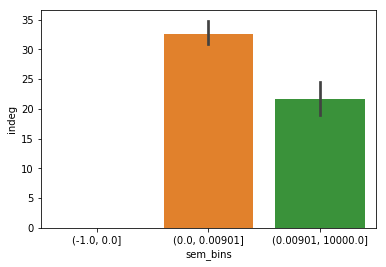

In [59]:
sns.barplot(y='indeg',x='sem_bins',data=df_dblp);

Again, docs with zero innovation are less cited, but most innovative docs are not most cited.

# 90s only

What if we correct for age by considering only the 90s

In [60]:
df_dblp_90s = df_dblp[(df_dblp['age'] < 30) & (df_dblp['age'] > 20)]

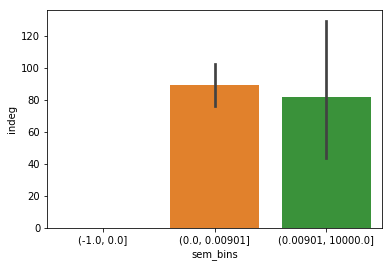

In [61]:
sns.barplot(y='indeg',x='sem_bins',data=df_dblp_90s);

Same story! Let's try regression for a better correction for age.

# Regression

In [63]:
from scipy.stats import spearmanr

## OPS

In [64]:
# simple poisson regression first
Y,X = patsy.dmatrices("indeg ~ age + sems + nuniqs",data=df_ops)
po_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(po_results.summary())
print(spearmanr(po_results.predict(X), Y))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  indeg   No. Observations:                 7544
Model:                            GLM   Df Residuals:                     7540
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3825e+05
Date:                Sun, 09 Dec 2018   Deviance:                   4.5460e+05
Time:                        00:02:41   Pearson chi2:                 2.65e+06
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7778      0.005    363.665      0.000       1.768       1.787
age            0.0146   7.71e-05    189.661      0.0

Very strong effect! Good!

How about the log number of citations for better fit?

In [65]:
df_ops['logdegree'] = np.log1p(df_ops['indeg'])
df_dblp['logdegree'] = np.log1p(df_dblp['indeg'])

In [68]:
Y,X = patsy.dmatrices("logdegree ~ age + sems + nuniqs",data=df_ops)
po_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(po_results.summary())
print(spearmanr(po_results.predict(X), Y))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              logdegree   No. Observations:                 7544
Model:                            GLM   Df Residuals:                     7540
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12317.
Date:                Sun, 09 Dec 2018   Deviance:                       10335.
Time:                        00:03:00   Pearson chi2:                 8.55e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1658      0.019     -8.718      0.000      -0.203      -0.129
age            0.0101      0.000     33.115      0.0

Now let's try binning with the binned semantics

In [69]:
Y,X = patsy.dmatrices("logdegree ~ age + sem_q + nuniqs",data=df_ops)
po_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(po_results.summary())
print(spearmanr(po_results.predict(X), Y))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              logdegree   No. Observations:                 7544
Model:                            GLM   Df Residuals:                     7536
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12311.
Date:                Sun, 09 Dec 2018   Deviance:                       10322.
Time:                        00:04:06   Pearson chi2:                 8.55e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                    

Less great -- all the action seems to be in distinguishing from the lowest bin.

## DBLP

In [46]:
Y,X = patsy.dmatrices("indeg ~ outdeg + age + sems + nuniqs + authors",data=df_dblp)
po_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(po_results.summary())
print(spearmanr(po_results.predict(X), Y))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  indeg   No. Observations:               250000
Model:                            GLM   Df Residuals:                   249994
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.2058e+06
Date:                Sun, 09 Dec 2018   Deviance:                   1.1640e+07
Time:                        00:01:10   Pearson chi2:                 7.21e+07
No. Iterations:                    13   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4029      0.002    908.523      0.000       1.400       1.406
outdeg         0.0173   1.48e-05   1170.606      0.0

Very strong positive weight for sems again. Good!

In [48]:
Y,X = patsy.dmatrices("logdegree ~ outdeg + age + sems + nuniqs + authors",data=df_dblp)
po_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(po_results.summary())
print(spearmanr(po_results.predict(X), Y))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              logdegree   No. Observations:               250000
Model:                            GLM   Df Residuals:                   249994
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.2336e+05
Date:                Sun, 09 Dec 2018   Deviance:                   3.5137e+05
Time:                        00:01:28   Pearson chi2:                 2.82e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3707      0.006    -63.824      0.000      -0.382      -0.359
outdeg         0.0134   8.13e-05    164.495      0.0

After logging the degree, the weight on sems is negative! I guess the previous regression was dominated by some extreme values?

In [49]:
Y,X = patsy.dmatrices("logdegree ~ outdeg + age + sem_bins + nuniqs + authors",data=df_dblp)
po_results = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
print(po_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              logdegree   No. Observations:               250000
Model:                            GLM   Df Residuals:                   249993
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.2333e+05
Date:                Sun, 09 Dec 2018   Deviance:                   3.5132e+05
Time:                        00:01:40   Pearson chi2:                 2.82e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                    

Documents with non-zero semantic innovation are cited more, but the most innovative documents are cited less than the ones in the middle.